In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import albumentations as albu
import torch
import yaml
from midv500models.train import SegmentDocs
from midv500models.utils import load_checkpoint, mask_overlay
import numpy as np
import cv2
from iglovikov_helper_functions.utils.image_utils import pad, unpad
from pylab import rcParams

In [3]:
rcParams['figure.figsize'] = 15, 15

In [4]:
config_path = "midv500models/configs/2020-05-19.yaml"
with open(config_path) as f:
    hparams = yaml.load(f, Loader=yaml.SafeLoader)

In [5]:
model = SegmentDocs(hparams)

In [6]:
model.load_state_dict(torch.load("Unet_Resnet34.pth"))
model.eval()
model.float();

In [7]:
image = cv2.imread("example.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
original_image = image.copy()

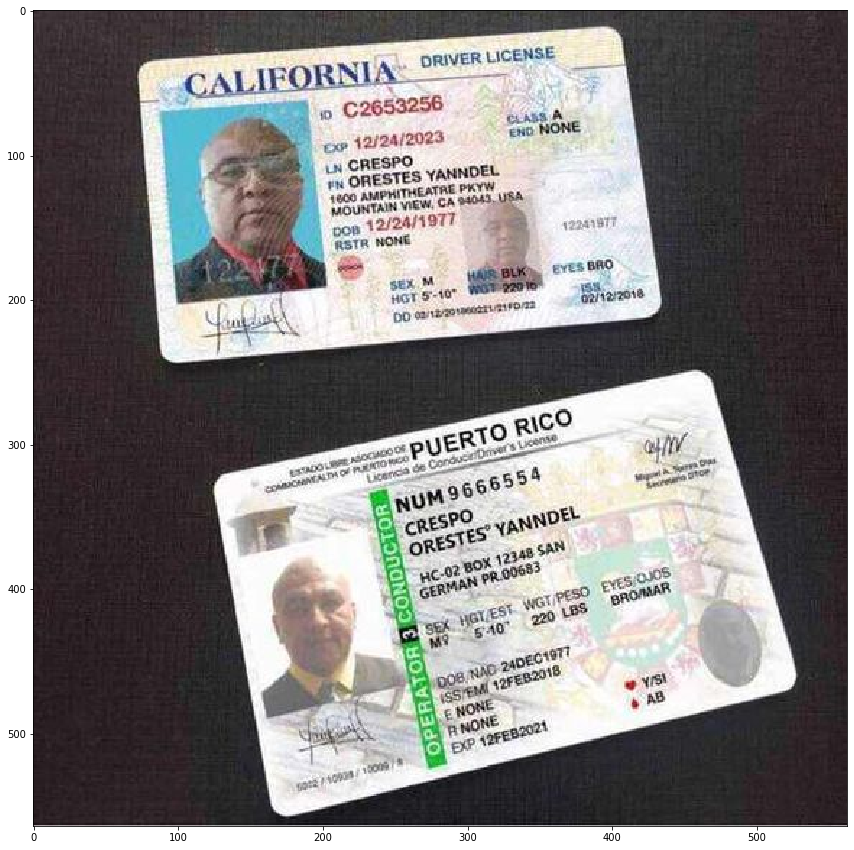

In [8]:
plt.imshow(image)

In [9]:
transform = albu.Compose([albu.LongestMaxSize(max_size=768, p=1), 
                          albu.Normalize(p=1)], p=1)

image, pads = pad(image, factor=768)

image = transform(image=image)["image"]
image = np.moveaxis(image, -1, 0)
image = np.ascontiguousarray(image)


In [10]:
predictions = model(torch.unsqueeze(torch.from_numpy(image), 0))

In [11]:
mask = (predictions[0][0] > 0).cpu().numpy().astype(np.uint8)
mask = unpad(mask, pads)

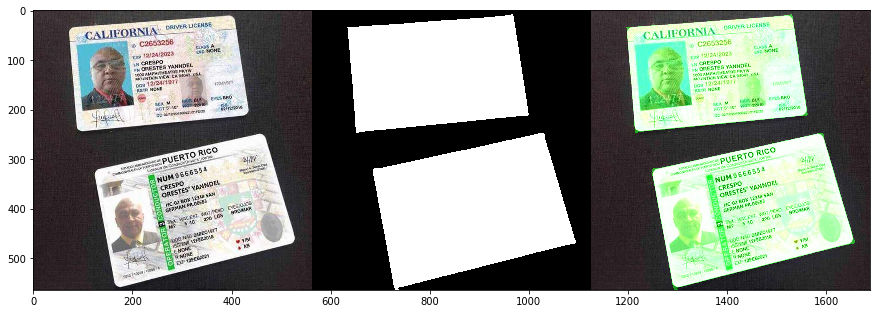

In [12]:
plt.imshow(np.hstack([original_image, cv2.cvtColor(mask * 255, cv2.COLOR_GRAY2RGB), mask_overlay(original_image, mask)]))